In [ ]:
import pandas as pd
import pickle

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
import sklearn.neighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

In [ ]:
pd.set_option('display.max_columns',None)

In [ ]:
# 0.1 load data from file
from google.colab import files
import io

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving static_defenses_yards.csv to static_defenses_yards.csv
User uploaded file "static_defenses_yards.csv" with length 4999907 bytes


In [ ]:
static_defenses = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')),index_col="id")
static_defenses.head()

,Unnamed: 0,defensivelinezonePlayers,deepzonePlayers,hookzonePlayers,curlzonePlayers,flatzonePlayers,defenseArea,defenseAreaCoverDefenders,width,height,numberQBs,numberWRs,numberTEs,numberRBs,numberFBs,numberOffensivePlayersAnotherPosition,numberSafeties,numberLBs,numberCBs,strongSide,numberPlayersDefenseStrongSide,numberPlayersDefenseWeakSide,numberPlayersOffenseStrongSide,numberPlayersOffenseWeakSide,differenceOffenseVsDefenseWidth,differenceOffenseVsDefenseStrongSide,differenceOffenseVsDefenseWeakSide,HeightByWeightDeep,HeightByWeightHook,HeightByWeightCurl,HeightByWeightFlat,WeightByArea,density,densityNoLine,densityInsidePoints,densityInsidePointsNoLine,playResult
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018090600:75:1,0,0,1,3,2,1,194.31095,194.31095,22.96,15.25,1,2,1,1,1,0,3,2,2,left,3,4,3,2,-0.63,0,-2,0.020227,0.018643,0.020066,0.021034,3.376032,0.036025,0.036025,6.974268,6.974268,10
2018090600:146:1,1,0,1,3,2,1,204.17725,204.17725,29.22,12.57,1,3,1,1,0,0,2,2,3,right,3,4,2,3,-1.15,-1,-1,0.020227,0.019228,0.020356,0.020455,3.178611,0.034284,0.034284,6.975511,6.975511,0
2018090600:168:1,2,0,1,2,2,2,277.65495,277.65495,33.67,15.21,1,2,1,2,0,0,2,2,3,left,5,2,4,1,0.71,-1,-1,0.020227,0.017683,0.020997,0.020745,2.337434,0.025211,0.025211,6.985594,6.985594,0
2018090600:190:1,3,1,0,2,3,1,189.16960,165.05520,26.42,12.91,1,3,1,1,0,0,3,1,3,right,2,5,2,3,-3.11,0,-2,0.000000,0.020120,0.021193,0.020455,3.192871,0.037004,0.036351,6.973569,6.969707,33
2018090600:320:1,5,1,0,3,3,1,187.12510,153.20020,27.80,13.29,1,3,1,1,0,0,2,3,3,left,3,5,3,2,-4.82,0,-3,0.000000,0.018995,0.019537,0.021279,4.281979,0.042752,0.045692,7.978624,7.980418,4


In [ ]:
static_defenses.drop(["Unnamed: 0"],axis=1,inplace=True)

In [ ]:
static_defenses.replace({"right":0,"left":1},inplace=True)

#Eliminar outliers

In [ ]:
#load dataset
pickle_file = open('outliers_minpts10_rs_3.pickle','rb')
outliers = pickle.load(pickle_file)
pickle_file.close()

In [ ]:
for play in list(outliers):
    static_defenses.drop(play,inplace=True)

#Eliminar big plays

##Big plays ofensivas

In [ ]:
static_defenses["playResult"].mean()

6.974169966494061

Vamos a seguir el siguiente criterio: a partir de 16 yardas es una big play en pase

Fuente: https://www.espn.com/blog/nflnation/post/_/id/73001/nfl-big-plays-who-and-what-makes-them

In [ ]:
len(static_defenses[static_defenses["playResult"]>=16])

2603

In [ ]:
len(static_defenses[static_defenses["playResult"]>=16]) / len(static_defenses) * 100

15.857447456594578

Representan el 16% de las jugadas, podríamos al menos estudiarlo por separarlo

In [ ]:
big_plays_offense = static_defenses[static_defenses["playResult"]>=16]

In [ ]:
static_defenses.drop(static_defenses[static_defenses["playResult"]>=16].index,inplace=True)

In [ ]:
len(static_defenses)

13812

##Big plays defensivas

In [ ]:
static_defenses[static_defenses["playResult"]<0]["playResult"].median()

-7.0

In [ ]:
static_defenses[static_defenses["playResult"]<=-7]

,defensivelinezonePlayers,deepzonePlayers,hookzonePlayers,curlzonePlayers,flatzonePlayers,defenseArea,defenseAreaCoverDefenders,width,height,numberQBs,numberWRs,numberTEs,numberRBs,numberFBs,numberOffensivePlayersAnotherPosition,numberSafeties,numberLBs,numberCBs,strongSide,numberPlayersDefenseStrongSide,numberPlayersDefenseWeakSide,numberPlayersOffenseStrongSide,numberPlayersOffenseWeakSide,differenceOffenseVsDefenseWidth,differenceOffenseVsDefenseStrongSide,differenceOffenseVsDefenseWeakSide,HeightByWeightDeep,HeightByWeightHook,HeightByWeightCurl,HeightByWeightFlat,WeightByArea,density,densityNoLine,densityInsidePoints,densityInsidePointsNoLine,playResult
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018090600:776:1,3,1,2,1,1,234.84220,163.61555,29.95,15.29,1,3,1,1,0,0,2,3,3,1,2,6,1,4,-0.25,-1,-2,0.018878,0.018251,0.020833,0.021279,2.854252,0.034065,0.030559,7.978709,7.975552,-7
2018090600:949:1,0,0,2,3,2,129.48690,129.48690,32.42,7.89,1,3,1,1,0,0,3,1,3,0,4,3,3,2,1.46,-1,-1,0.000000,0.018484,0.021035,0.020745,4.896248,0.054060,0.054060,6.969109,6.969109,-7
2018090600:1568:1,0,0,1,6,0,162.57650,162.57650,22.58,12.45,1,3,1,1,0,0,3,1,3,0,3,4,1,4,-1.15,-2,0,0.000000,0.020227,0.020223,0.000000,3.899703,0.043057,0.043057,6.975396,6.975396,-9
2018090600:2503:1,0,1,2,2,2,240.30520,240.30520,33.16,12.69,1,3,1,1,0,0,3,1,3,0,4,3,3,2,2.45,-1,-1,0.020227,0.018484,0.021439,0.020745,2.638312,0.029130,0.029130,6.975032,6.975032,-12
2018090600:3626:1,2,0,2,4,0,154.37785,147.44340,24.25,11.99,1,2,2,1,0,0,2,3,3,0,5,3,3,2,-5.87,-2,-1,0.000000,0.019512,0.019799,0.000000,3.669205,0.051821,0.040694,7.961134,7.959306,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018123015:1694:17,3,1,1,1,1,206.35020,137.89705,27.53,14.91,1,3,1,1,0,0,3,2,2,0,2,5,2,3,0.17,0,-2,0.019892,0.019892,0.020227,0.020109,2.654154,0.033923,0.029007,6.975769,6.970993,-8
2018123015:1921:17,0,0,3,2,2,124.16935,124.16935,36.07,8.24,1,3,1,1,0,0,3,2,2,0,4,3,3,2,-0.12,-1,-1,0.000000,0.019759,0.018591,0.020001,5.315321,0.056375,0.056375,6.967786,6.967786,-7
2018123015:2469:17,1,1,2,1,2,266.35375,261.58220,31.15,16.07,1,3,1,1,0,0,3,2,2,1,5,2,3,2,-0.32,-2,0,0.019892,0.019526,0.020227,0.020001,2.114058,0.026281,0.022937,6.977474,6.977063,-8


In [ ]:
big_play_offense = static_defenses[static_defenses["playResult"]<=-7]

In [ ]:
static_defenses.drop(static_defenses[static_defenses["playResult"]<=-7].index,inplace=True)

#Normalización de los datos

In [ ]:
scaler = preprocessing.StandardScaler()
static_defenses1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.MinMaxScaler()
static_defenses2 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.RobustScaler()
static_defenses3 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.PowerTransformer()
static_defenses4 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

#PCA

In [ ]:
pca_ss = PCA ()
X_pca_ss = pca_ss.fit_transform(static_defenses1)
X_pca_ss.shape

(13055, 35)

In [ ]:
pca_mms = PCA ()
X_pca_mms = pca_mms.fit_transform(static_defenses2)
X_pca_mms.shape

(13055, 35)

In [ ]:
pca_rs = PCA ()
X_pca_rs = pca_rs.fit_transform(static_defenses3)
X_pca_rs.shape

(13055, 35)

In [ ]:
pca_pt = PCA ()
X_pca_pt = pca_pt.fit_transform(static_defenses4)
X_pca_pt.shape

(13055, 35)

In [ ]:
exp_var_cumul = np.cumsum(pca_ss.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

Para este 14 componentes

In [ ]:
exp_var_cumul = np.cumsum(pca_mms.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

Para este 8 componentes

In [ ]:
exp_var_cumul = np.cumsum(pca_rs.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "Número de componentes", "y": "Variabilidad"}
)

Para este 5 componentes

In [ ]:
exp_var_cumul = np.cumsum(pca_pt.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

Para este 13 componentes

#Nuevos datasets

In [ ]:
X_pca_ss = PCA(n_components = 14).fit_transform(static_defenses1)
X_pca_ss.shape

(13055, 14)

In [ ]:
X_pca_mms = PCA(n_components = 8).fit_transform(static_defenses2)
X_pca_mms.shape

(13055, 8)

In [ ]:
X_pca_rs = PCA(n_components = 5).fit_transform(static_defenses3)
X_pca_rs.shape

(13055, 5)

In [ ]:
X_pca_pt = PCA(n_components = 13).fit_transform(static_defenses4)
X_pca_pt.shape

(13055, 13)

#KNN

##StandardScaler

In [ ]:
train_ss = pd.DataFrame(X_pca_ss)
train_ss["playResult"] = static_defenses["playResult"].values
train_ss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,playResult
0,-0.774207,-2.468463,0.494566,1.864442,2.134126,-0.167689,-1.035529,2.170305,1.481364,1.282113,-4.053152,1.791275,-0.521982,0.693632,10
1,-0.050022,-1.812451,1.506638,-0.269917,-0.550293,0.652475,-1.825971,0.446371,0.143673,-0.281565,0.558406,-0.310550,-0.510448,0.446715,0
2,2.290472,-2.538432,-3.218413,1.618976,0.525982,-0.480004,-0.323774,-0.103402,-1.648391,3.647438,0.568316,-0.831422,0.013317,-0.263231,0
3,-1.455413,-1.673324,2.751002,-1.874452,0.495801,-0.928747,-0.089102,1.235334,-0.949319,-0.706386,0.283102,-0.117368,-0.609669,0.547714,33
4,-1.647651,0.858845,0.729530,-0.845751,2.025989,-1.865085,-0.695295,0.816665,-0.857215,-0.145110,-0.575788,0.279939,0.620699,-0.725182,4


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_pca_ss, static_defenses["playResult"], test_size=0.2)

Min Value uniform : 7.979604783846378 (29)
Min Value distance : 8.004468836325767 (29)


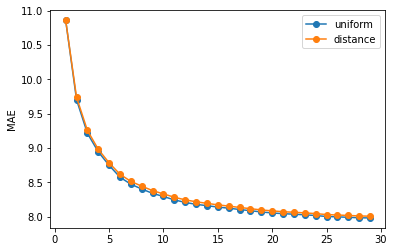

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

cv = KFold(n_splits = 10, shuffle = False) #


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train_ss):
          # División train test aleatoria
          f_train = train_ss.loc[train_fold]
          f_test = train_ss.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(["playResult"],axis=1), y = f_train['playResult'])
          y_pred = knn.predict(X = f_test.drop(['playResult'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['playResult'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 



In [ ]:
# constructor
n_neighbors = 29
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
mae = mean_absolute_error(y_test,y_pred)
print ('MAE', mae)

MAE 8.063398699675444


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



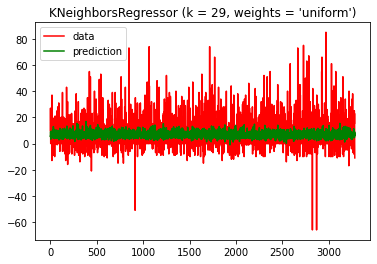

In [ ]:

from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

##MinMaxScaler

In [ ]:
train_ss = pd.DataFrame(X_pca_ss)
train_ss["playResult"] = static_defenses["playResult"].values
train_ss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,playResult
0,-0.774207,-2.468463,0.494566,1.864442,2.134126,-0.167689,-1.035529,2.170305,1.481364,1.282113,-4.053152,1.791275,-0.521982,0.693632,10
1,-0.050022,-1.812451,1.506638,-0.269917,-0.550293,0.652475,-1.825971,0.446371,0.143673,-0.281565,0.558406,-0.310550,-0.510448,0.446715,0
2,2.290472,-2.538432,-3.218413,1.618976,0.525982,-0.480004,-0.323774,-0.103402,-1.648391,3.647438,0.568316,-0.831422,0.013317,-0.263231,0
3,-1.455413,-1.673324,2.751002,-1.874452,0.495801,-0.928747,-0.089102,1.235334,-0.949319,-0.706386,0.283102,-0.117368,-0.609669,0.547714,33
4,-1.647651,0.858845,0.729530,-0.845751,2.025989,-1.865085,-0.695295,0.816665,-0.857215,-0.145110,-0.575788,0.279939,0.620699,-0.725182,4


In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

cv = KFold(n_splits = 10, shuffle = False) #


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train_ss):
          # División train test aleatoria
          f_train = train_ss.loc[train_fold]
          f_test = train_ss.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(["playResult"],axis=1), y = f_train['playResult'])
          y_pred = knn.predict(X = f_test.drop(['playResult'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['playResult'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 



Min Value uniform : 7.979604783846378 (29)


In [ ]:
# constructor
n_neighbors = 7
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
mae = mean_absolute_error(y_test,y_pred)
print ('MAE', mae)

MAE 8.383012053435445


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



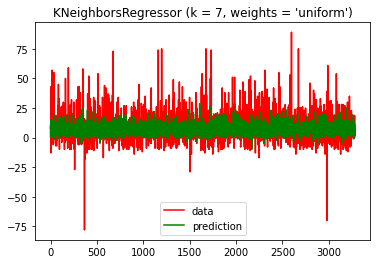

In [ ]:

from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

##RobustScaler

In [ ]:
train_ss = pd.DataFrame(X_pca_ss)
train_ss["playResult"] = static_defenses["playResult"].values
train_ss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,playResult
0,-0.774207,-2.468463,0.494566,1.864442,2.134126,-0.167689,-1.035529,2.170305,1.481364,1.282113,-4.053152,1.791275,-0.521982,0.693632,10
1,-0.050022,-1.812451,1.506638,-0.269917,-0.550293,0.652475,-1.825971,0.446371,0.143673,-0.281565,0.558406,-0.310550,-0.510448,0.446715,0
2,2.290472,-2.538432,-3.218413,1.618976,0.525982,-0.480004,-0.323774,-0.103402,-1.648391,3.647438,0.568316,-0.831422,0.013317,-0.263231,0
3,-1.455413,-1.673324,2.751002,-1.874452,0.495801,-0.928747,-0.089102,1.235334,-0.949319,-0.706386,0.283102,-0.117368,-0.609669,0.547714,33
4,-1.647651,0.858845,0.729530,-0.845751,2.025989,-1.865085,-0.695295,0.816665,-0.857215,-0.145110,-0.575788,0.279939,0.620699,-0.725182,4


In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

cv = KFold(n_splits = 10, shuffle = False) #


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train_ss):
          # División train test aleatoria
          f_train = train_ss.loc[train_fold]
          f_test = train_ss.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(["playResult"],axis=1), y = f_train['playResult'])
          y_pred = knn.predict(X = f_test.drop(['playResult'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['playResult'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 



Min Value uniform : 7.979604783846378 (29)


In [ ]:
# constructor
n_neighbors = 7
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
mae = mean_absolute_error(y_test,y_pred)
print ('MAE', mae)

MAE 8.383012053435445


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



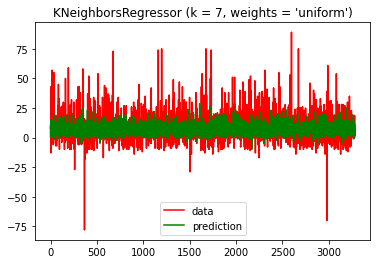

In [ ]:

from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

##PowerTransformer

In [ ]:
train_ss = pd.DataFrame(X_pca_ss)
train_ss["playResult"] = static_defenses["playResult"].values
train_ss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,playResult
0,-0.774207,-2.468463,0.494566,1.864442,2.134126,-0.167689,-1.035529,2.170305,1.481364,1.282113,-4.053152,1.791275,-0.521982,0.693632,10
1,-0.050022,-1.812451,1.506638,-0.269917,-0.550293,0.652475,-1.825971,0.446371,0.143673,-0.281565,0.558406,-0.310550,-0.510448,0.446715,0
2,2.290472,-2.538432,-3.218413,1.618976,0.525982,-0.480004,-0.323774,-0.103402,-1.648391,3.647438,0.568316,-0.831422,0.013317,-0.263231,0
3,-1.455413,-1.673324,2.751002,-1.874452,0.495801,-0.928747,-0.089102,1.235334,-0.949319,-0.706386,0.283102,-0.117368,-0.609669,0.547714,33
4,-1.647651,0.858845,0.729530,-0.845751,2.025989,-1.865085,-0.695295,0.816665,-0.857215,-0.145110,-0.575788,0.279939,0.620699,-0.725182,4


In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

cv = KFold(n_splits = 10, shuffle = False) #


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train_ss):
          # División train test aleatoria
          f_train = train_ss.loc[train_fold]
          f_test = train_ss.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(["playResult"],axis=1), y = f_train['playResult'])
          y_pred = knn.predict(X = f_test.drop(['playResult'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['playResult'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 



Min Value uniform : 7.979604783846378 (29)


In [ ]:
# constructor
n_neighbors = 7
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
mae = mean_absolute_error(y_test,y_pred)
print ('MAE', mae)

MAE 8.383012053435445


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



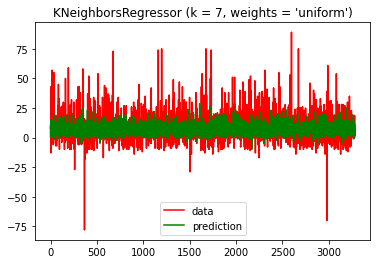

In [ ]:

from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

#Decision Trees

##StandardScaler

In [ ]:
train_ss = pd.DataFrame(X_pca_ss)
train_ss["playResult"] = static_defenses["playResult"].values
train_ss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,playResult
0,-0.796762,-2.471063,0.379461,1.883567,2.239644,-0.251087,-1.068815,1.946789,1.118577,1.753095,3.898092,-2.202849,-0.734660,0.513202,10
1,-0.073693,-1.840949,1.472369,-0.208183,-0.523825,0.593292,-1.869386,0.429098,0.173242,-0.302880,-0.498872,0.308035,-0.453472,0.379695,0
2,2.280870,-2.498068,-3.336658,1.542837,0.516549,-0.466786,-0.256591,-0.182319,-2.152436,3.307750,-1.291831,-0.108190,-0.009529,-0.236027,0
3,-1.676263,0.859091,0.705002,-0.887539,2.034705,-1.883532,-0.668118,0.783034,-0.891376,-0.172149,0.556749,-0.397043,0.549093,-0.754143,4
4,0.181136,0.085060,-2.481506,-0.073147,0.939430,2.312026,0.419620,-0.602379,-0.245800,-1.052889,-0.620646,0.135918,-0.282336,-0.459047,0


No handles with labels found to put in legend.


Min Value  :4.352378349329421 (3)


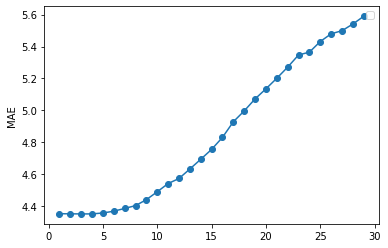

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False) #
#  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html 


total_scores = []
for i in range(1,30):
    fold_accuracy = []
    dt = DecisionTreeRegressor(max_depth=i)
    # verificar cada uno de los modelos con validación cruzada.
    for train_fold, test_fold in cv.split(train_ss):
      # División train test aleatoria
      f_train = train_ss.loc[train_fold]
      f_test = train_ss.loc[test_fold]
      # entrenamiento y ejecución del modelo
      dt.fit( X = f_train.drop(['playResult'], axis=1), 
                            y = f_train['playResult'])
      y_pred = dt.predict(X = f_test.drop(['playResult'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['playResult'], y_pred)
      fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
plt.plot(range(1,len(total_scores)+1), total_scores, 
           marker='o')
print ('Min Value  :' +  str(min(total_scores)) +' (' + str(np.argmin(total_scores) + 1) + ')')
plt.ylabel('MAE')      
    

plt.legend()
plt.show() 

###Ejecución

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_ss.drop(["playResult"],axis=1),train_ss["playResult"],test_size=0.2)

In [ ]:
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
mae = mean_absolute_error(y_test, y_pred)
print ('MAE', mae)


MAE 4.364333846865527


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



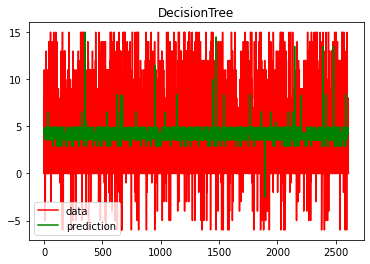

In [ ]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTree")

plt.show()

##MinMaxScaler

##RobustScaler

##PowerTransformer

#RandomForest

##StandardScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_ss.drop(["playResult"],axis=1),train_ss["playResult"],test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#1.1 Model Parametrization 
regressor = RandomForestRegressor(n_estimators= 100, max_depth = 10, criterion='mae', random_state=0)
#1.2 Model construction
regressor.fit(X_train, y_train)

# Test
y_pred = regressor.predict(X_test)

# metrics calculation 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test,y_pred)
print ("Error Measure ",  mae)

Error Measure  4.36284565300651


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



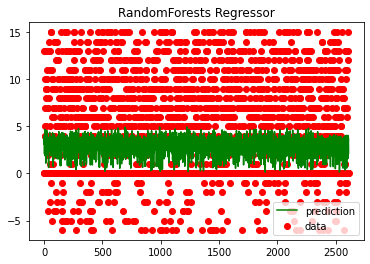

In [ ]:
#plt.subplot(2, 1, i + 1)
# x axis for plotting
import matplotlib.pyplot as plt
import numpy as np

xx = np.stack(i for i in range(len(y_test)))
plt.scatter(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor")

plt.show()

##MinMaxScaler

##RobustScaler

##PowerTransformer

#Boosting

##StandardScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_ss.drop(["playResult"],axis=1),train_ss["playResult"],test_size=0.2)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor  
regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5, criterion='mae'),n_estimators=100)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("Error Measure", mean_absolute_error(y_test,y_pred))

Error Measure 4.69609345078514


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



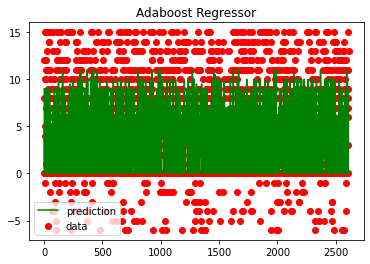

In [ ]:
xx = np.stack(i for i in range(len(y_test)))
plt.scatter(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("Adaboost Regressor")

plt.show()

##MinMaxScaler

##RobustScaler

##PowerTransformer